<a href="https://colab.research.google.com/github/agarr3/vajra/blob/master/LSTM_AUTO_ENCODER_Indian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Just Like that test code -


In [1]:
import torch
import torch.nn as nn

input_dim = 5
hidden_dim = 10
n_layers = 1

lstm_layer = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

batch_size = 2
seq_len = 3

inp = torch.randn(batch_size, seq_len, input_dim)
hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
cell_state = torch.randn(n_layers, batch_size, hidden_dim)
hidden = (hidden_state, cell_state)

out, hidden = lstm_layer(inp, hidden)
print("Output shape: ", out.shape)
print("Hidden: ", hidden[1].shape)
print(hidden[1].repeat(inp.shape).shape)
print(hidden[1].repeat(inp.shape).shape[0])

Output shape:  torch.Size([2, 3, 10])
Hidden:  torch.Size([1, 2, 10])
torch.Size([2, 6, 50])
2


Start of the code. Mount Western dataset

In [2]:
import torch

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import numpy as np

import os
files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk("/content/drive/My Drive/Indian_numpy"):
  for file in fileList:
    if(True):
      files.append(os.path.join(r,file))
    else:
      print(file)

    
    # dimension = np.load(os.path.join(r,file),  mmap_mode='r')
    # if(dimension.shape == (26,400)):
    #   files.append(os.path.join(r,file))
    # else:
    #   print(file)

(len(files))

western_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk("/content/drive/My Drive/Western_numpy"):
  for file in fileList:
    if(file not in exclusion):
      western_files.append(os.path.join(r,file))
    else:
      print(file)

western_files = western_files[:2008]

Mounted at /content/drive
098567.npy
098569.npy
098565.npy


In [4]:
print(len(files))
print(len(western_files))

2008
2008


COnfiguration for Auto encoder

In [5]:
class configeration:
  seq_len = 200
  input_dim = 26
  embedding_dim = 64
  batch_size = 2
  base_dir = "/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MEL/Indian-balanced"
  loss_function = torch.nn.MSELoss(reduction='sum')
  lr=1e-3
  n_epochs = 90
  model_file = "/models/mel.pkl"
  results_dir = os.path.join(base_dir, "./results")
  checkpoint_model_file = "/models/mel_checkpoint.pkl"

Start of auto encoder for MEL

In [6]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    #x = x.reshape((1, self.seq_len, self.n_features))
    #print(x.shape)
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return x

In [7]:
class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    #print("in decoder", x.shape)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

In [8]:
class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [9]:
x = torch.randn(5, 26, 400)
print(x.shape)
x = x.permute(0, 2, 1)
print(x.shape)

encoder = Encoder(400, 26, 64)
encoded = encoder(x)
print(encoded.shape)

decoder = Decoder(400, 64, 26)
decoded = decoder(encoded)
print(decoded.shape)

rae = RecurrentAutoencoder(400, 26, 64)
output = rae(x)

print(output.shape)

torch.Size([5, 26, 400])
torch.Size([5, 400, 26])
torch.Size([5, 400, 64])
torch.Size([5, 400, 26])
torch.Size([5, 400, 26])


In [10]:
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SequentialSampler

class CustomDatasetMel(Dataset):

    def __init__(self, dataList, labelList):
        self.data = dataList
        self.labels = labelList

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        import numpy as np
        fileName = self.data[index]
        
        mel_spect = np.load(fileName)
        data = torch.tensor(mel_spect[:,:200], dtype=torch.float)
        data = data.permute(1, 0)
        #data = torch.unsqueeze(data, dim =0)

        label = torch.tensor(self.labels[index])
        return data, label

class CustomDatasetMNIST(Dataset):

    def __init__(self, dataDF):
        self.data = dataDF
        
    def __len__(self):
        return len(self.data.index)

    def __getitem__(self, index):
        import numpy as np
        
        data = self.data.iloc[index][1:].tolist()
        data = torch.tensor(data, dtype=torch.float)
        data = data.view(28,28)

        label = self.data.iloc[index][0]
        label = torch.tensor(label)
        return data, label

In [ ]:
import torchvision
import torch

from torchvision import transforms, datasets
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SequentialSampler

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

def load_mnist(path='/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MNIST_TEST/data', download=False, batch_size=100, shift_pixels=2):
        """
        Construct dataloaders for training and test data. Data augmentation is also done here.
        :param path: file path of the dataset
        :param download: whether to download the original data
        :param batch_size: batch size
        :param shift_pixels: maximum number of pixels to shift in each direction
        :return: train_loader, test_loader
        """
        kwargs = {'num_workers': 1, 'pin_memory': True}

        train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(path, train=True, download=download,
                           transform=transforms.Compose([transforms.RandomCrop(size=28, padding=shift_pixels),
                                                         transforms.ToTensor()])),
            batch_size=batch_size, shuffle=True, **kwargs)
        test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(path, train=False, download=download,
                           transform=transforms.ToTensor()),
            batch_size=batch_size, shuffle=True, **kwargs)

        return train_loader, test_loader

train_loader, test_loader = load_mnist(download=False)


# path='/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MNIST_TEST/data'
# mnist = datasets.MNIST(path, train=True, download=False,
#                            transform=transforms.Compose([transforms.RandomCrop(size=28, padding=2),
#                                                          transforms.ToTensor()]))

# print(mnist.__getitem__(1)[0].shape)

import pandas as pd
train_df = pd.read_csv("/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MNIST_TEST/data/MNIST/mnist_train.csv")
print(train_df.iloc[0][1:].tolist())

import numpy as np 
from PIL import Image

# array = np.array(train_df.iloc[0][1:].tolist())

# array = np.reshape(array, (28, 28))
# print(array)
# data = Image.fromarray(np.uint8(array)).convert('RGB')
# data

train_df.iloc[0]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 18, 18, 18, 126, 136, 175, 26, 166, 255, 247, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 36, 94, 154, 170, 253, 253, 253, 253, 253, 225, 172, 253, 242, 195, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 238, 253, 253, 253, 253, 253, 253, 253, 253, 251, 93, 82, 82, 56, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 219, 253, 253, 253, 253, 253, 198, 182, 247, 241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 156, 107, 253, 253, 205, 11, 0, 43, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 1, 154, 253, 90, 0, 

label    5
1x1      0
1x2      0
1x3      0
1x4      0
        ..
28x24    0
28x25    0
28x26    0
28x27    0
28x28    0
Name: 0, Length: 785, dtype: int64

In [ ]:
import copy
import math
import numpy as np

import torch

class TrainingWrapper:

  def __init__(self, config, training_loader, test_loader, device, val_loader=None):
    self.config = config
    self.training_loader = training_loader
    self.test_loader = test_loader
    self.val_loader = val_loader
    self.device = device
    self.model = RecurrentAutoencoder(self.config.seq_len, self.config.input_dim, self.config.embedding_dim, device=self.device)
    self.model = self.model.to(self.device)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config.lr)
    self.criterion = self.config.loss_function.to(self.device)
    self.history = dict(train=[], val=[], cross_val=[])
    self.best_model_wts = copy.deepcopy(self.model.state_dict())
    self.best_loss = 10000.0
    print(self.config.base_dir + self.config.model_file)
    torch.save(self.model.state_dict(), self.config.base_dir + self.config.model_file)

  def combine_images(self, generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image


  def show_reconstruction(self, test_loader, n_images):
    import matplotlib.pyplot as plt
    
    from PIL import Image
    import numpy as np

    self.model.eval()
    for x, _ in self.test_loader:
        x = x[:min(n_images, x.size(0))].to(self,device)
        _, x_recon = self.model(x)
        data = np.concatenate([x.data.cpu(), x_recon.data.cpu()])
        img = self.combine_images(np.transpose(data, [0, 2, 3, 1]))
        image = img * 255
        Image.fromarray(image.astype(np.uint8)).save(self.config.base_dir + "/real_and_recon.png")
        print()
        print('Reconstructed images are saved to %s/real_and_recon.png' % self.config.base_dir)
        print('-' * 70)
        plt.imshow(plt.imread(self.config.base_dir + "/real_and_recon.png", ))
        plt.show()
        break

  def visualizeTraining(self, epoch, trn_losses, tst_losses, val_losses, save_dir):
    # visualize the loss as the network trained
    print("trn_losses..... ",trn_losses)
    print("tst_losses..... ",tst_losses)
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 8))
    plt.plot(range(0, len(trn_losses)), trn_losses, label='Training Loss')
    if tst_losses:
      plt.plot(range(0, len(tst_losses)), tst_losses, label='Validation Loss')
    if val_losses:
      plt.plot(range(0, len(val_losses)), val_losses, label='Cross Validation Loss')
    minposs = tst_losses.index(min(tst_losses))
    plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')


    plt.xlabel('epochs')
    plt.ylabel('loss')
    # plt.ylim(0, 0.5)  # consistent scale
    # plt.xlim(0, len(trn_losses))  # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(save_dir , 'loss_plot_{}.png'.format(epoch)), bbox_inches='tight')

  def train(self):
    for epoch in range(1, self.config.n_epochs + 1):
      self.model = self.model.train()
      train_losses = []

      for i, (x, y) in enumerate(self.training_loader):
        self.optimizer.zero_grad()
        x = x.to(self.device)
        y = y.to(self.device)

        output = self.model(x)
        loss = self.criterion(output, x)

        loss.backward()
        self.optimizer.step()
        train_losses.append(loss.item())
        print("in training loop, epoch {}, step {}, the loss is {}".format(epoch, i, loss.item()))

      val_losses = []
      self.model = self.model.eval()
      with torch.no_grad():
        for i, (x, y) in enumerate(self.test_loader):
          x = x.to(device)
          y = y.to(device)
          output = self.model(x)
          loss = self.criterion(output, x)
          val_losses.append(loss.item())

      cross_val_losses = []
      self.model = self.model.eval()
      with torch.no_grad():
        for i, (x, y) in enumerate(self.val_loader):
          x = x.to(device)
          y = y.to(device)
          output = self.model(x)
          loss = self.criterion(output, x)
          cross_val_losses.append(loss.item())


      train_loss = np.mean(train_losses)
      val_loss = np.mean(val_losses)
      cross_val_loss = np.mean(cross_val_losses)

      self.history['train'].append(train_loss)
      self.history['val'].append(val_loss)
      self.history['cross_val'].append(cross_val_loss)

      if val_loss < self.best_loss:
        self.best_loss = val_loss
        self.best_model_wts = copy.deepcopy(self.model.state_dict())
      if epoch % 2 == 0:
        self.visualizeTraining(epoch, trn_losses= self.history['train'], tst_losses=self.history['val'], val_losses =self.history['cross_val'], save_dir=self.config.base_dir + "/results")
        torch.save(self.model.state_dict(), self.config.base_dir + self.config.checkpoint_model_file)
      print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    self.model.load_state_dict(self.best_model_wts)
    torch.save(self.model.state_dict(), self.config.base_dir + self.config.model_file)
    return self.model.eval(), self.history

  
class TestingWrapper:
  def __init__(self, config, device):
    self.config = config
    self.device = device
    self.model = RecurrentAutoencoder(self.config.seq_len, self.config.input_dim, self.config.embedding_dim, device=self.device)
    PATH = self.config.base_dir + self.config.checkpoint_model_file
    print(PATH)
    self.model.load_state_dict(torch.load(PATH, map_location=self.device))
    self.model = self.model.to(self.device)

  def combine_images(self, generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image


  def show_reconstruction(self, test_loader, n_images):
    import matplotlib.pyplot as plt
    
    from PIL import Image
    import numpy as np

    self.model.eval()
    for x, _ in test_loader:
      x = x[:min(n_images, x.size(0))].to(self.device)
      x_recon = self.model(x)
      data = np.concatenate([x.data.cpu(), x_recon.data.cpu()])
      img = self.combine_images(np.transpose(data, [0, 2, 3, 1]))
      image = img * 255
      Image.fromarray(image.astype(np.uint8)).save(self.config.base_dir + "/real_and_recon.png")
      print()
      print('Reconstructed images are saved to %s/real_and_recon.png' % self.config.base_dir)
      print('-' * 70)
      plt.imshow(plt.imread(self.config.base_dir + "/real_and_recon.png", ))
      plt.show()
      break

  def save_reconstruction(self, test_loader):
    import matplotlib.pyplot as plt
    
    from PIL import Image
    import numpy as np
    import uuid


    self.model.eval()
    with torch.no_grad(): 
      fileCount = 0
      for x, _ in test_loader:
        x = x.to(self.device)
        x_recon = self.model(x)
        x_recon = x_recon.data.cpu().detach().numpy()
        for mel in x_recon:
          print(mel.shape)
          unique_filename = str(uuid.uuid4())
          filename = self.config.base_dir + "/reconstruction/" + unique_filename + ".npy"
          np.save(filename, mel)
          fileCount = fileCount + 1
          print("saving file {} with index {}".format(filename, fileCount))



mode = 'train'
data = "mel"
#data = "mnist"
config = configeration()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed=1234):
  import random
  import os
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.backends.cudnn.deterministic = True

seed_everything()

if data=="mnist":
  config.seq_len = 28
  config.input_dim = 28
  config.embedding_dim = 64
  config.batch_size = 100
  config.base_dir = "/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MNIST_TEST"
  config.model_file = "/models/mnist.pkl"
  config.results_dir = os.path.join(config.base_dir, "./results")
  
  #train_loader, test_loader = load_mnist(os.path.join(config.base_dir, "./data"), download=False, batch_size=config.batch_size)
  train_df = pd.read_csv("/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MNIST_TEST/data/MNIST/mnist_train.csv")
  test_df = pd.read_csv("/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MNIST_TEST/data/MNIST/mnist_test.csv")

  train_dataset = CustomDatasetMNIST(train_df)
  test_data_set = CustomDatasetMNIST(test_df)

  train_loader = DataLoader(train_dataset,
                                  batch_size=config.batch_size,
                                  sampler=SequentialSampler(train_dataset), drop_last=False)

  test_loader = DataLoader(test_data_set,
                                batch_size=config.batch_size,
                                sampler=SequentialSampler(test_data_set), drop_last=False)

else:
  train_data = files
  labels = [1] * len(files)

  val_data = western_files
  val_labels = [1] * len(western_files)

  train_dataset = CustomDatasetMel(train_data, labels)
  test_data_set = CustomDatasetMel(train_data, labels)
  val_data_set = CustomDatasetMel(val_data, val_labels)

  train_loader = DataLoader(train_dataset,
                                  batch_size=config.batch_size,
                                  sampler=SequentialSampler(train_dataset), drop_last=False)

  test_loader = DataLoader(test_data_set,
                                batch_size=config.batch_size,
                                sampler=SequentialSampler(test_data_set), drop_last=False)
  
  val_loader = DataLoader(val_data_set,
                                batch_size=config.batch_size,
                                sampler=SequentialSampler(val_data_set), drop_last=False)


if mode=="train":
  trainingWrapper = TrainingWrapper(config=config, training_loader=train_loader, test_loader=test_loader, device=device, val_loader=val_loader)
  model, history = trainingWrapper.train()

  if data=="mnist":
    #trainingWrapper.show_reconstruction(test_loader=test_loader, n_images=50)
    pass

elif mode=='test':
  testWrapper = TestingWrapper(config=config, device=device)
  testWrapper.save_reconstruction(test_loader)



In [ ]:
import numpy as np 
from PIL import Image

model = RecurrentAutoencoder(28, 28, 64, device=device)
PATH = "/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MNIST_TEST/models/mnist.pkl"
print(PATH)
model.load_state_dict(torch.load(PATH, map_location=device))
model = model.to(device)

array = np.array(train_df.iloc[0][1:].tolist())

array = np.reshape(array, (28, 28))
array = torch.tensor(array,dtype=torch.float)
array = array.unsqueeze(dim=0)
array = array.to(device)
print(array)
array = model(array)
print(array)
array = array.squeeze(dim=0)
data = Image.fromarray(np.uint8(array.cpu().detach().numpy())).convert('RGB')
data

trn_losses.....  [8, 4, 5]
tst_losses.....  [8, 4, 5]


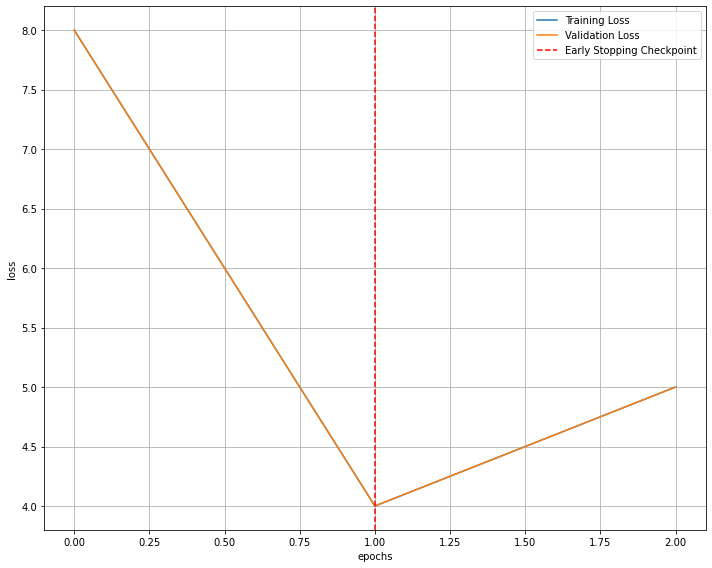

In [ ]:
def visualizeTrainingTest(epoch, trn_losses, tst_losses, save_dir):
    # visualize the loss as the network trained
    print("trn_losses..... ",trn_losses)
    print("tst_losses..... ",tst_losses)
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 8))
    plt.plot(range(0, len(trn_losses)), trn_losses, label='Training Loss')
    if tst_losses:
      plt.plot(range(0, len(tst_losses)), tst_losses, label='Validation Loss')
    
    minposs = tst_losses.index(min(tst_losses))
    plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')


    plt.xlabel('epochs')
    plt.ylabel('loss')
    # plt.ylim(0, 0.5)  # consistent scale
    # plt.xlim(0, len(trn_losses))  # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(10, 8))
# trn_losses = [8,4,5]
# plt.plot(range(0, len(trn_losses)), trn_losses, label='Training Loss')
# plt.show()

trn_losses = [8,4,5]

visualizeTrainingTest(3,trn_losses,trn_losses,'/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MEL/Indian/models/')